# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.921839,False,-3.162412
1,-0.727158,False,-0.411692
2,-0.628189,False,-2.747116
3,-0.966405,False,-0.284689
4,-0.302111,False,-0.845632
...,...,...,...
995,-0.964924,False,-1.987335
996,0.580303,True,7.927165
997,0.332588,False,-0.610100
998,-0.558305,False,-1.521874


<Axes: xlabel='v0'>

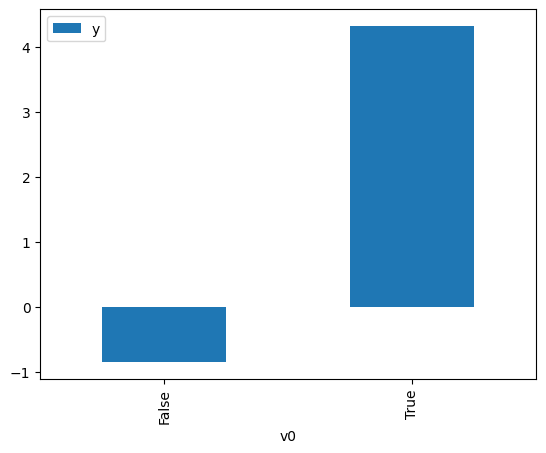

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

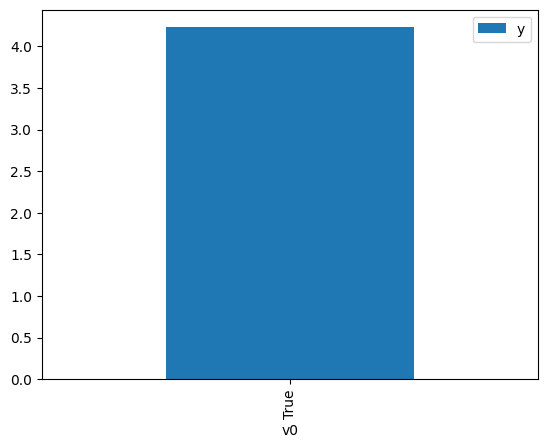

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.383141,False,-0.641008,0.549504,1.819822
1,-1.307789,False,-1.647073,0.641089,1.559847
2,-0.884262,False,-0.140178,0.599980,1.666721
3,-0.057427,False,-0.053624,0.516072,1.937715
4,0.192399,False,1.144771,0.490315,2.039507
...,...,...,...,...,...
995,0.804121,False,0.879748,0.427738,2.337880
996,-1.128837,False,-2.891065,0.623932,1.602738
997,-1.094288,False,0.458060,0.620582,1.611390
998,-1.262602,False,-3.085060,0.636788,1.570380


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.071010,True,3.643999,0.497168,2.011392
1,-0.130863,True,4.981763,0.476367,2.099221
2,0.640052,True,6.150117,0.555620,1.799790
3,-1.203151,True,3.000128,0.368903,2.710743
4,-0.616986,True,4.066106,0.426748,2.343302
...,...,...,...,...,...
995,1.225548,True,8.188521,0.614182,1.628181
996,-0.277881,True,4.606692,0.461266,2.167947
997,-0.037943,True,6.270507,0.485936,2.057885
998,0.094173,True,3.762668,0.499557,2.001774


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.918
Model:                            OLS   Adj. R-squared (uncentered):              0.918
Method:                 Least Squares   F-statistic:                              5600.
Date:                Sun, 26 Oct 2025   Prob (F-statistic):                        0.00
Time:                        04:40:20   Log-Likelihood:                         -1425.1
No. Observations:                1000   AIC:                                      2854.
Df Residuals:                     998   BIC:                                      2864.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.4892      0.029     51.093      0.000       1.432       1.546
x2             4.9960      0.049    101.226      0.000       4.899       5.093
==============================================================================
Omnibus:                        2.151   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.341   Jarque-Bera (JB):                2.020
Skew:                           0.102   Prob(JB):                        0.364
Kurtosis:                       3.081   Cond. No.                         1.77
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""